# Autoencoder

# Gaussian Noise

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, transforms
import matplotlib.pyplot as plt

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5), (0.5))])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,batch_size=64,shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,batch_size=64,shuffle=True)

In [16]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [17]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [18]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [19]:
model_denoise = Autoencoder()
# model = Autoencoder_Linear()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_denoise.parameters(),lr=1e-3,weight_decay=1e-5)

In [20]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        noisy_img = img + 0.5 * torch.randn_like(img)
        noisy_img = torch.clamp(noisy_img, 0., 1.)
        
        recon = model_denoise(noisy_img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, noisy_img, recon))

Epoch:1, Loss:0.0212
Epoch:2, Loss:0.0139
Epoch:3, Loss:0.0134
Epoch:4, Loss:0.0119
Epoch:5, Loss:0.0122
Epoch:6, Loss:0.0120
Epoch:7, Loss:0.0117
Epoch:8, Loss:0.0102
Epoch:9, Loss:0.0115
Epoch:10, Loss:0.0105


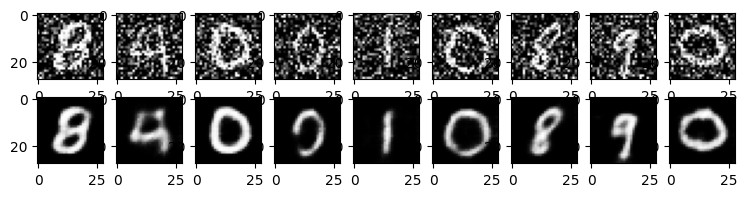

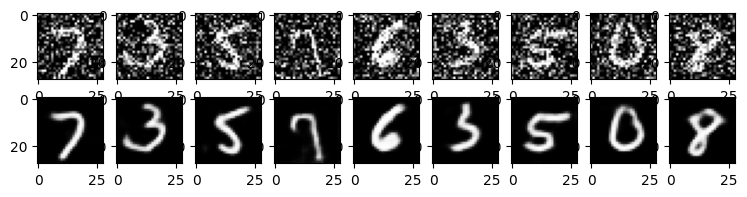

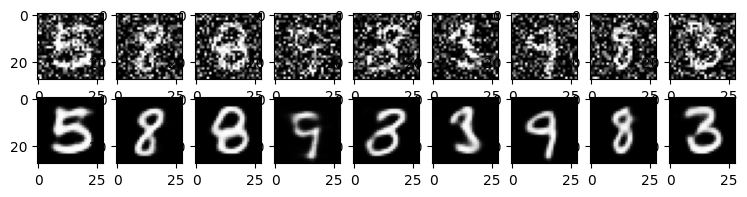

In [21]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()

    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28,28)
        plt.imshow(item[0])

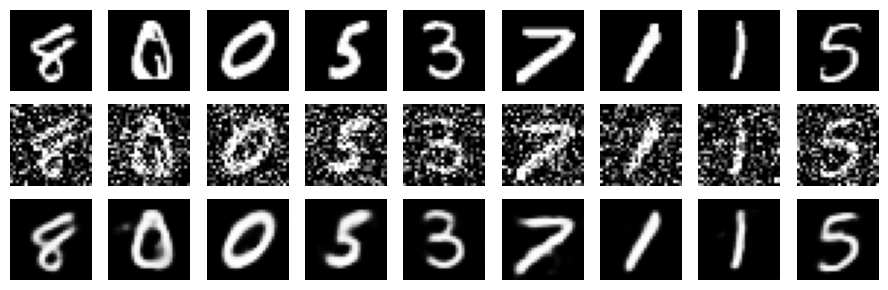

In [22]:
model_denoise.eval()

dataiter = iter(data_loader_valid)
images, labels = next(dataiter)

plt.figure(figsize=(9, 3))
plt.gray()

for i, img in enumerate(images[:9]):
    with torch.no_grad():
        noisy = img + 0.5 * torch.randn_like(img)
        noisy = torch.clamp(noisy, 0., 1.)
        
        pred = model_denoise(noisy.unsqueeze(0))
        recon = pred[0].detach().numpy()

        plt.subplot(3, 9, i+1)
        plt.imshow(img[0])
        plt.axis('off')

        plt.subplot(3, 9, i+10)
        plt.imshow(noisy[0])
        plt.axis('off')

        plt.subplot(3, 9, i+19)
        plt.imshow(recon[0])
        plt.axis('off')

plt.tight_layout()
plt.show()

# Super-resolution

In [23]:
class Autoencoder_SR(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [24]:
model_sr = Autoencoder_SR()
optimizer = torch.optim.Adam(model_sr.parameters(), lr=1e-3)
outputs = []

for epoch in range(10):
    for (img, _) in data_loader:
        low_res = F.interpolate(img, size=(7, 7), mode='bilinear')
        
        recon = model_sr(low_res)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    #outputs.append((epoch, img, recon))
    outputs.append((epoch, low_res, img, recon))


Epoch:1, Loss:0.0235
Epoch:2, Loss:0.0231
Epoch:3, Loss:0.0231
Epoch:4, Loss:0.0213
Epoch:5, Loss:0.0223
Epoch:6, Loss:0.0198
Epoch:7, Loss:0.0244
Epoch:8, Loss:0.0221
Epoch:9, Loss:0.0204
Epoch:10, Loss:0.0199


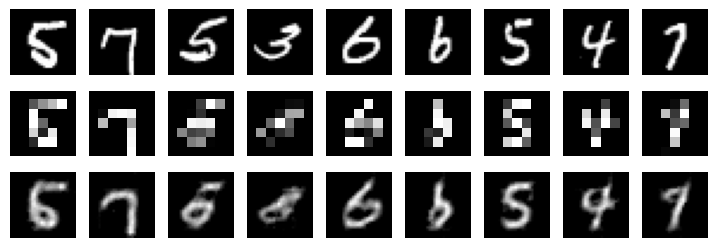

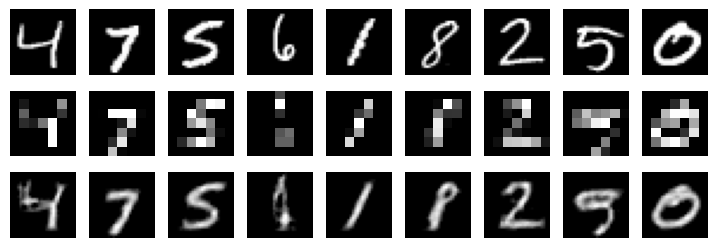

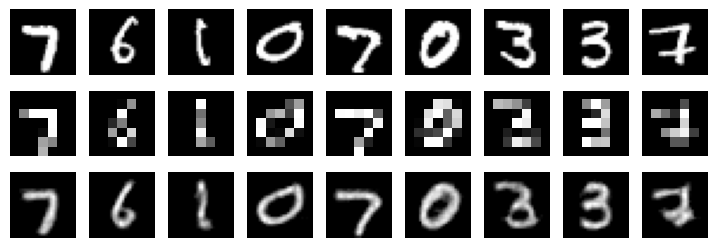

In [25]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 3))
    lr_in, gt_out, recon_out = outputs[k][1].detach(), outputs[k][2].detach(), outputs[k][3].detach()

    for i in range(9):
        plt.subplot(3, 9, 9 + i + 1); plt.imshow(lr_in[i][0]); plt.axis('off')
        plt.subplot(3, 9, i + 1); plt.imshow(gt_out[i][0]); plt.axis('off')
        plt.subplot(3, 9, 18 + i + 1); plt.imshow(recon_out[i][0]); plt.axis('off')

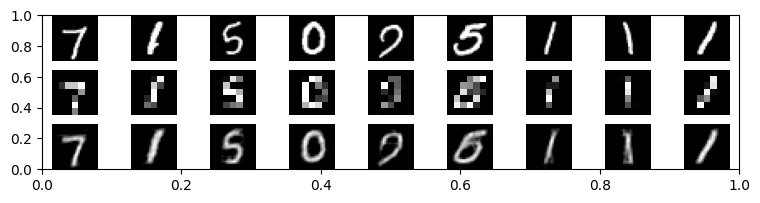

In [26]:
model_sr.eval()

dataiter = iter(data_loader_valid)
images, labels = next(dataiter)

img = images[0]

plt.figure(figsize=(9, 2))
plt.gray()
plt.axis()

for i, img in enumerate(images[:9]):
    with torch.no_grad():
        low_res = F.interpolate(img.unsqueeze(0), size=(7, 7), mode='bilinear')
        pred = model_sr(low_res)
        recon = pred[0].detach().numpy()

        plt.subplot(3, 9, i+1)
        plt.imshow(img[0])
        plt.axis('off')

        plt.subplot(3, 9, i+10)
        plt.imshow(low_res[0][0])
        plt.axis('off')

        plt.subplot(3, 9, i+19)
        plt.imshow(recon[0])
        plt.axis('off')
plt.show()